<a href="https://colab.research.google.com/github/dayaiit/Machine-Learning/blob/main/L9_Simple_CNN_Example_for_EKG_Classification_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

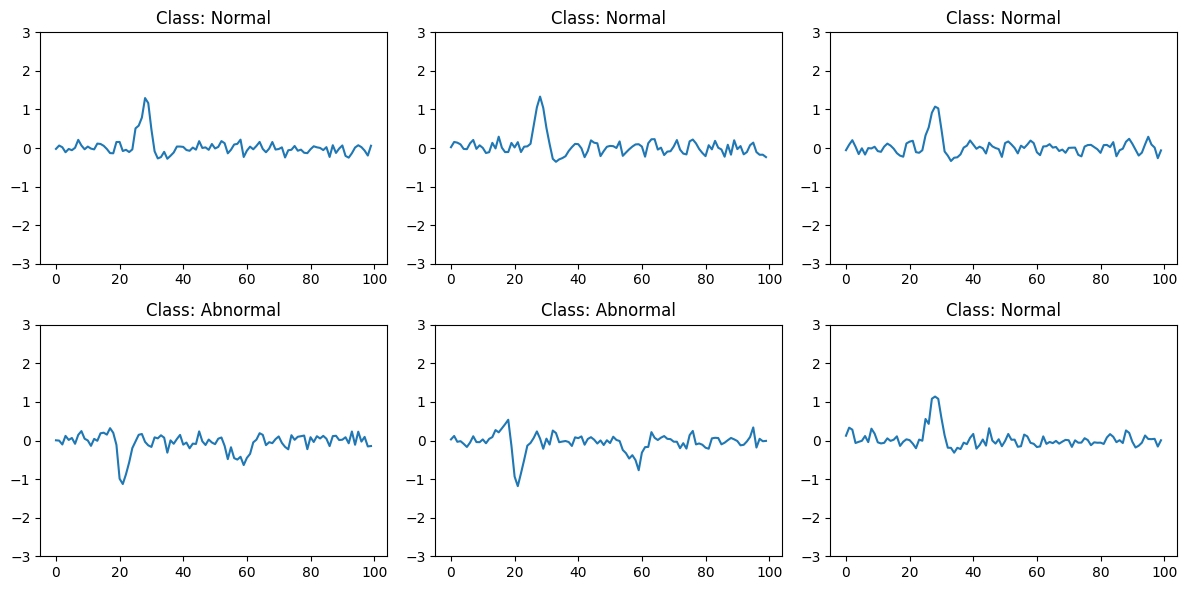

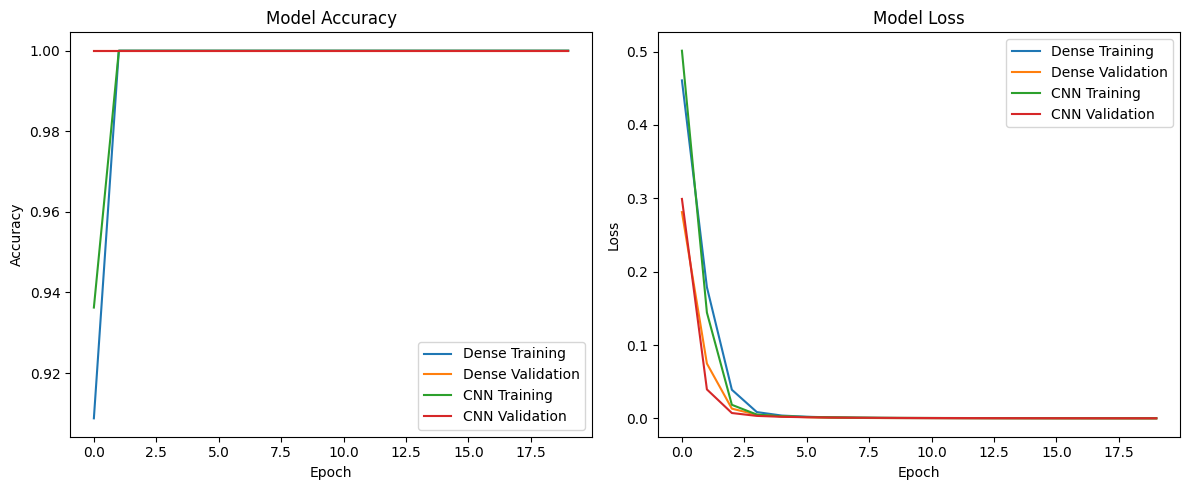

Dense Model Validation Accuracy: 1.0000
Convolutional Model Validation Accuracy: 1.0000


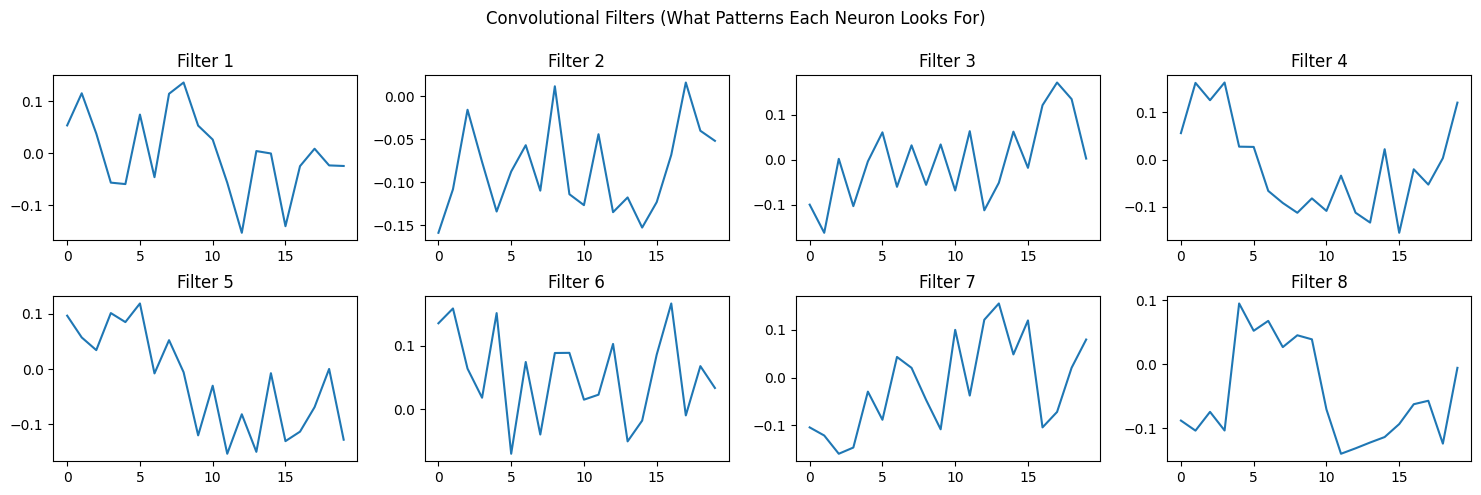

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(1, 100, 1))
  warnings.warn(msg)


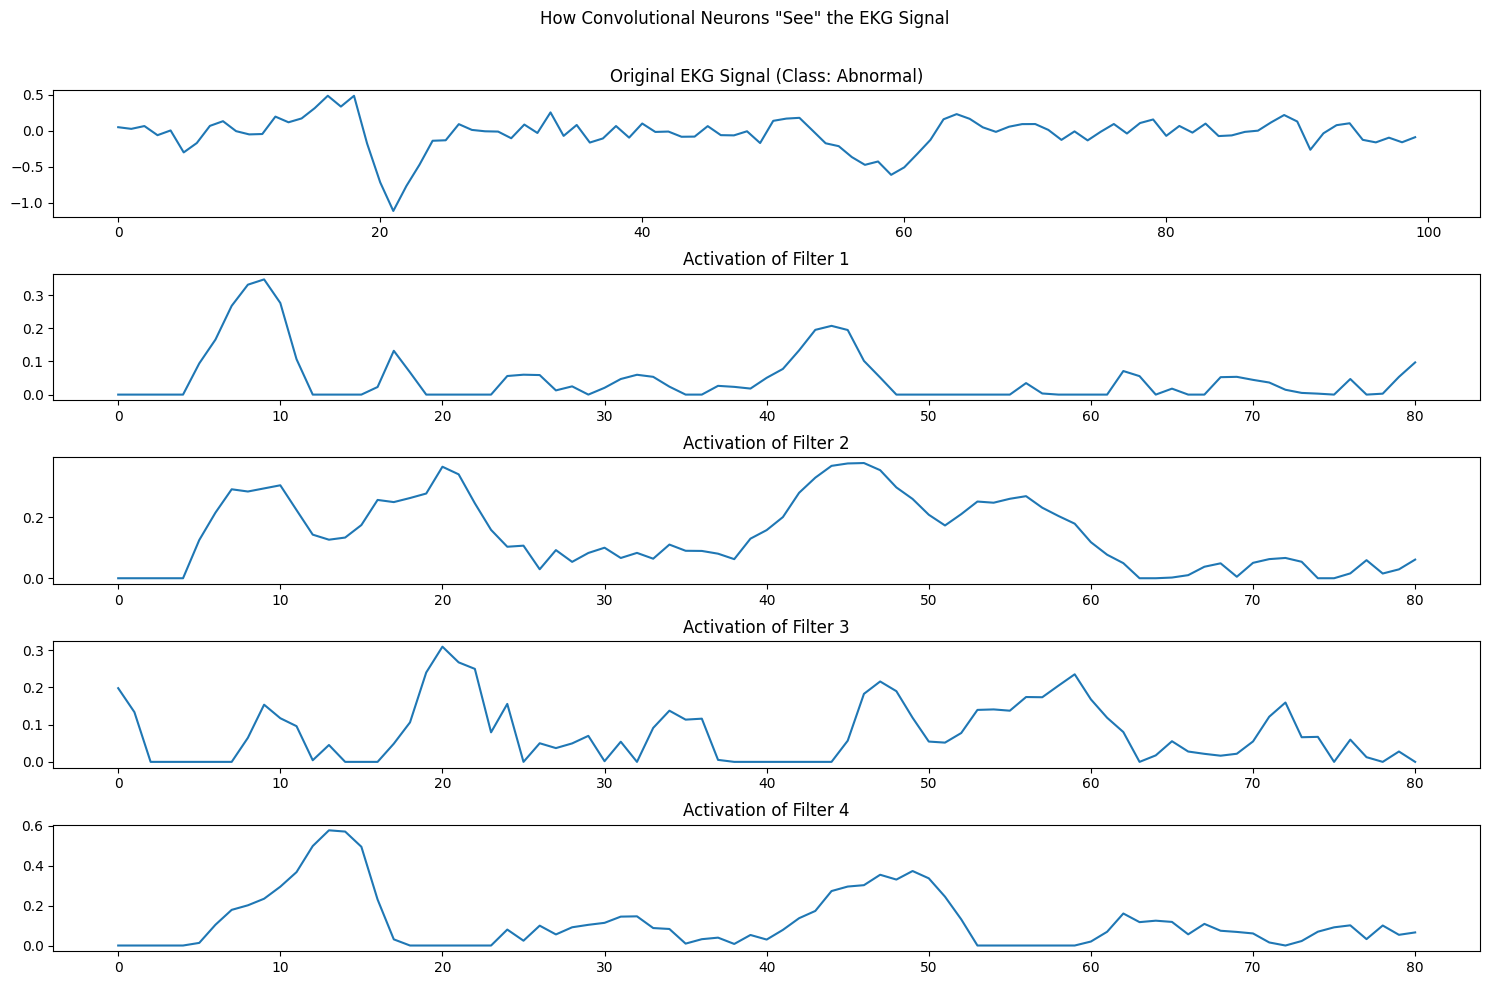

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

# Generate synthetic EKG-like data for demonstration
def generate_ekg_signal(num_samples=1000, num_points=100):
    # Normal heartbeat pattern (simplified)
    def normal_heartbeat(x):
        return 0.1 * np.sin(x) + np.exp(-0.1 * (x - 30)**2) * np.sin(x*0.3) * 2

    # Abnormal heartbeat pattern (simplified)
    def abnormal_heartbeat(x):
        return 0.1 * np.sin(x) + np.exp(-0.1 * (x - 20)**2) * np.sin(x*0.5) * 1.5 + np.exp(-0.1 * (x - 60)**2) * np.sin(x*0.2)

    X = []
    y = []

    for i in range(num_samples):
        # Generate time points
        time_points = np.linspace(0, 100, num_points)

        # Randomly choose normal or abnormal
        is_normal = np.random.choice([0, 1])

        if is_normal:
            # Generate normal heartbeat with some noise
            signal = normal_heartbeat(time_points) + np.random.normal(0, 0.1, num_points)
            y.append(0)  # Label 0 for normal
        else:
            # Generate abnormal heartbeat with some noise
            signal = abnormal_heartbeat(time_points) + np.random.normal(0, 0.1, num_points)
            y.append(1)  # Label 1 for abnormal

        X.append(signal)

    return np.array(X).reshape(-1, num_points, 1), np.array(y)

# Generate our synthetic data
X, y = generate_ekg_signal(num_samples=1000)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot some examples
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(X[i].flatten())
    plt.title(f"Class: {'Abnormal' if y[i] == 1 else 'Normal'}")
    plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

# Now let's create two models: one with Dense layers and one with Convolutional layers

# 1. Dense model
dense_model = Sequential([
    Flatten(input_shape=(100, 1)),  # Flatten the input
    Dense(64, activation='relu'),   # Dense layer with 64 neurons
    Dense(32, activation='relu'),   # Another dense layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Convolutional model
conv_model = Sequential([
    # First convolutional layer - each neuron looks at 20 time points
    Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=(100, 1)),
    MaxPooling1D(pool_size=2),  # Reduce dimensionality

    # Second convolutional layer - each neuron looks at 5 outputs from previous layer
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),  # Reduce dimensionality

    # Flatten the output to feed into a dense layer
    Flatten(),

    # Output layer
    Dense(1, activation='sigmoid')
])

conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Let's train both models and compare
dense_history = dense_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=0
)

conv_history = conv_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=0
)

# Plot the training history to compare
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(dense_history.history['accuracy'], label='Dense Training')
plt.plot(dense_history.history['val_accuracy'], label='Dense Validation')
plt.plot(conv_history.history['accuracy'], label='CNN Training')
plt.plot(conv_history.history['val_accuracy'], label='CNN Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(dense_history.history['loss'], label='Dense Training')
plt.plot(dense_history.history['val_loss'], label='Dense Validation')
plt.plot(conv_history.history['loss'], label='CNN Training')
plt.plot(conv_history.history['val_loss'], label='CNN Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Print the final validation accuracy for both models
dense_val_acc = dense_model.evaluate(X_test, y_test, verbose=0)[1]
conv_val_acc = conv_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"Dense Model Validation Accuracy: {dense_val_acc:.4f}")
print(f"Convolutional Model Validation Accuracy: {conv_val_acc:.4f}")

# Visualize the convolutional filters (what patterns they're detecting)
# Let's get the weights from the first conv layer
conv_weights = conv_model.layers[0].get_weights()[0]

plt.figure(figsize=(15, 5))
for i in range(min(8, conv_weights.shape[2])):  # Show up to 8 filters
    plt.subplot(2, 4, i+1)
    plt.plot(conv_weights[:, 0, i])
    plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.suptitle('Convolutional Filters (What Patterns Each Neuron Looks For)')
plt.subplots_adjust(top=0.85)
plt.show()

# Let's show what the convolutional layer is actually doing by visualizing activations
# Instead of creating a separate model, we'll use a different approach

# Define a function to get the activations from a specific layer
def get_activations(model, layer_index, input_data):
    # Create a temporary model that goes from the input to the desired layer
    temp_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=model.layers[layer_index].output
    )
    # Get the activations
    return temp_model.predict(input_data)

# First, we need to make sure the model has been called at least once
# (we've already trained it, so this should be fine, but let's be safe)
_ = conv_model.predict(X_test[:1])  # Just to initialize the model

# Now get activations for a single example
sample_idx = 5  # Choose an example from the test set
sample = X_test[sample_idx:sample_idx+1]

try:
    # Try getting activations using the function
    activations = get_activations(conv_model, 0, sample)

    # Plot the input signal and its activations
    plt.figure(figsize=(15, 10))

    # Plot the original signal
    plt.subplot(5, 1, 1)
    plt.plot(sample[0])
    plt.title(f"Original EKG Signal (Class: {'Abnormal' if y_test[sample_idx] == 1 else 'Normal'})")

    # Plot some of the activations (up to 4)
    for i in range(min(4, activations.shape[2])):
        plt.subplot(5, 1, i+2)
        plt.plot(activations[0, :, i])
        plt.title(f'Activation of Filter {i+1}')

except Exception as e:
    print(f"Couldn't visualize activations due to: {e}")
    print("This is an advanced visualization - the rest of the code works fine!")

    # Let's at least show the original signal
    plt.figure(figsize=(10, 4))
    plt.plot(sample[0])
    plt.title(f"Original EKG Signal (Class: {'Abnormal' if y_test[sample_idx] == 1 else 'Normal'})")
    plt.ylabel("Amplitude")
    plt.xlabel("Time")

plt.tight_layout()
plt.suptitle('How Convolutional Neurons "See" the EKG Signal')
plt.subplots_adjust(top=0.9)
plt.show()